# Linear Gaussian Model
$x_k = x_{k-1} + \epsilon_{x,k}$

$y_k = x_k + \epsilon_{y}$

$\epsilon_{x,k} \sim N(0, \sigma^2_e)$

$\epsilon_{y} \sim N(0, \sigma^2_v)$, $\sigma^2_v = 5$

# Particle Filter 
(all operations are for i = 1, ..., N)

1: Draw $x_1^i \sim q_1(x_1|y_1)$

2: Compute $w_1^i = w_1(x_1^i;y_1)$

3: Normalize: set $W_1^i = w_1^i/\sum_l w_1^l$

4: for $k \ge 2$ do

5: Resample with $P(a_{k-1}^i = x_{k-1}^j )= W_{k-1}^j$

6: Draw $x_k^i \sim q_k(x_k|y_k, a_{k-1}^i)$ and set $x_{1:k}^i = \{a_{1:k-1}^i, x_k^i \}$

7: Compute $w_k^i = w_k(x_k^i, a_{k-1}^i ;y_k)$

8: Normalize: set $W_k^i = w_k^i/\sum_l w_k^l$

9: end for

$w_k(x_k^i, a_{k-1}^i ;y_k) = \frac{g(y_k|x_k)f(x_k|x_{k-1})}{q_k(x_k|y_k, a_{k-1}^i)}$

### 1st Try: $q_k = p(x_k|y_k, H_k)$ precomputed Kalman filter

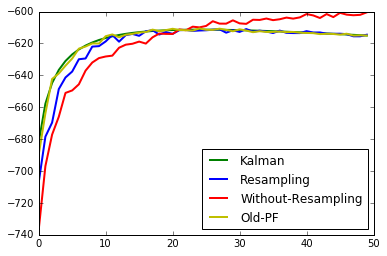

In [364]:
Image(filename='LinearGaussianLikelihoodCompare.png')

### 2nd Try:  $q_k = p(x_k|y_k, a_{k-1}^i)$

$N(x_{k-1}^i + \frac{\sigma_e^2}{\sigma_e^2+\sigma_v^2}(y_k - x_{k-1}^i),(\frac{1}{\sigma_e^2}+\frac{1}{\sigma_v^2})^{-1})$

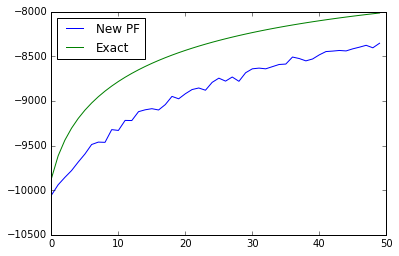

In [366]:
Image(filename='LinearGaussian_neuron19.png')

### 3rd Try:  Auxiliary Particle Filter
 $w_k(x_k^i, a_{k-1}^i ;y_k) = \frac{g(y_k|x_k)f(x_k|x_{k-1})}{q_k(x_k|y_k, a_{k-1}^i)p(y_k|a_{k-1}^i)}$

$p(y_k|a_{k-1}^i) = N(y_k-a_{k-1}^i, \sigma^2_v)$

$p(y_k|y_{1:k-1}) = (\frac{1}{N}\sum_i w_k^i)(\sum_i p(y_{k+1}|x_k^i)W_k^i)$

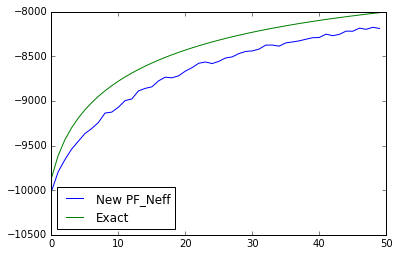

In [367]:
Image(filename='APF_neuron19.png')

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
#!python
from numpy import *
from numpy.random import *
%matplotlib inline
import os
import time
import numpy as np
import pandas as pd
import sys
import cPickle as pickle
from   random import *
import scipy.stats
import matplotlib.pyplot as plt
import pyparticleest.utils.kalman as kalman
from IPython.display import Image

import numpy as np
import scipy as sp
import scipy.special
import scipy.linalg

import os
os.getcwd()
import sys

sys.path.insert(1,'/Users/zyzrdfz/Documents/ss_model_mixture/Cython_Code')
from fastloop import resample

In [61]:
# df = pd.read_csv('thaldata.csv',header=None)
# Y = df.values.reshape(3000)
# Y = Y[500:800]
# T = len(Y)
mat = np.loadtxt('train_data.txt')
Y = mat[19,1:]
T = len(Y)

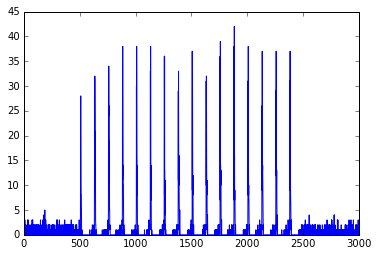

In [4]:
plt.plot(Y)

In [62]:
sigma2v = 5
sigma2e = np.arange(0.01, 0.51, 0.01)
print sigma2e

[ 0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11  0.12
  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23  0.24
  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35  0.36
  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47  0.48
  0.49  0.5 ]


In [63]:
def gaussian(X, Q):
    #log-pdf of p(x_t|x_{t-1})
    return -0.5 * (l2pi + np.log(Q) + (X ** 2) / Q)

In [89]:
# Forward particles
N = 5000
#
l2pi = math.log(2 * math.pi)

In [94]:
def filtering2(T, N, Q, Y, sigma2v):
    samples = np.random.normal(0,1,[T,N])
    X = np.empty([T,N])
    ancestor = np.empty([T,N])
    w = np.empty([T,N])
    z = np.empty([T,N])
    pi = np.empty([T,N])
    W = np.empty([T,N])
    ##Initialization
    t = 0
    x_prior = 0.0
    s2_prior = Q
    x_post = x_prior + s2_prior/(s2_prior + sigma2v)*(Y[t] - x_prior)
    s2_post = 1.0/(1.0/sigma2v +1.0/s2_prior)
    X[t,:] = x_post + np.sqrt(s2_post + 3* Q) * samples[t,:]
    w[t,:] = gaussian(Y[t]-X[t,:], sigma2v) + gaussian(X[t,:], Q) - gaussian(X[t,:] - x_post, s2_post + 3*Q)
    W[t,:] = np.exp(w[t,:] - np.max(w[t,:]))
    W[t,:] /= np.sum(W[t,:])
    z[t,:] = W[t,:] * np.exp(gaussian(Y[t+1]-X[t,:], sigma2v))
    pi[t,:] = z[t,:]/np.sum(z[t,:])
    ancestor[t,:]= X[t,resample(pi[t,:])]
    
    for tt in range(T-2):
        t=tt+1
        x_prior = ancestor[tt,:]
        s2_prior = Q
        x_post = x_prior + s2_prior/(s2_prior + sigma2v)*(Y[t] - x_prior)
        s2_post = 1.0/(1.0/sigma2v +1.0/s2_prior)
        X[t,:] = x_post + np.sqrt(s2_post + 3*Q) * samples[t,:]
        w[t,:] = gaussian(Y[t]-X[t,:], sigma2v) + gaussian(X[t,:] - ancestor[tt,:], Q) - gaussian(X[t,:] - x_post, s2_post + 3*Q) - gaussian(Y[t]- ancestor[tt,:],sigma2v + Q)    
        W[t,:] = np.exp(w[t,:] - np.max(w[t,:]))
        W[t,:] /= np.sum(W[t,:])
        z[t,:] = W[t,:] * np.exp(gaussian(Y[t+1]- X[t,:],sigma2v + Q))
        pi[t,:] = z[t,:]/np.sum(z[t,:])
        ancestor[t,:]= X[t,resample(pi[t,:])]
    
    t=T-1
    x_prior = ancestor[t-1,:]
    s2_prior = Q
    x_post = x_prior + s2_prior/(s2_prior + sigma2v)*(Y[t] - x_prior)
    s2_post = 1.0/(1.0/sigma2v +1.0/s2_prior)
    X[t,:] = x_post + np.sqrt(s2_post + 3*Q) * samples[t,:]
    w[t,:] = gaussian(Y[t]-X[t,:], sigma2v) + gaussian(X[t,:] - ancestor[t-1,:], Q) - gaussian(X[t,:] - x_post, s2_post + 3*Q)
    W[t,:] = np.exp(w[t,:] - np.max(w[t,:]))
    W[t,:] /= np.sum(W[t,:])
    z[t,:] = W[t,:]
    ancestor[t,:]= X[t,resample(W[t,:])]
    
    return X, w, W, ancestor, z

In [44]:
def filtering(T, N, Q, Y, sigma2v):
    samples = np.random.normal(0,1,[T,N])
    X = np.empty([T,N])
    ancestor = np.empty([T,N])
    w = np.empty([T,N])
    W = np.empty([T,N])
    ##Initialization
    t = 0
    x_prior = 0.0
    s2_prior = Q
    x_post = x_prior + s2_prior/(s2_prior + sigma2v)*(Y[t] - x_prior)
    s2_post = 1.0/(1.0/sigma2v +1.0/s2_prior)
    X[t,:] = x_post + np.sqrt(s2_post) * samples[t,:]
    w[t,:] = gaussian(Y[t]-X[t,:], sigma2v) + gaussian(X[t,:], Q) - gaussian(X[t,:] - x_post, s2_post)
    W[t,:] = np.exp(w[t,:] - np.max(w[t,:]))
    W[t,:] /= np.sum(W[t,:])
    ancestor[t,:]= X[t,resample(W[t,:])]
    
    for tt in range(T-1):
        t=tt+1
        x_prior = ancestor[tt,:]
        s2_prior = Q
        x_post = x_prior + s2_prior/(s2_prior + sigma2v)*(Y[t] - x_prior)
        s2_post = 1.0/(1.0/sigma2v +1.0/s2_prior)
        X[t,:] = x_post + np.sqrt(s2_post) * samples[t,:]
        w[t,:] = gaussian(Y[t]-X[t,:], sigma2v) + gaussian(X[t,:] - ancestor[tt,:], Q) - gaussian(X[t,:] - x_post, s2_post)   
        W[t,:] = np.exp(w[t,:] - np.max(w[t,:]))
        W[t,:] /= np.sum(W[t,:])
        ancestor[t,:]= X[t,resample(W[t,:])]
    
    return X, w, W, ancestor, 

In [45]:
loglikelihood_withresampling = np.empty(len(sigma2e))

In [95]:
for i in range(len(sigma2e)):
    Q = sigma2e[i]
    [X, w, W, ancestor, z] = filtering2(T, N, Q, Y, sigma2v)    
#     maxlogweight = np.max(w, axis=1)
#     weight = np.exp(w - np.reshape(np.repeat(maxlogweight, N),(T, N)))
#     loglikelihood_withresampling[i] = np.sum(np.log(np.sum(weight, axis = 1)/N))+np.sum(maxlogweight)
    
    loglikelihood_withresampling[i] = np.sum(np.log(np.sum(z[:T-2], axis = 1))) + np.sum(np.log(np.sum(np.exp(w[:T-2]), axis =1)/N))

In [65]:
def filtering3(T, N, Q, Y, mode, variance):
    samples = np.random.normal(0,1,[T,N])
    X = np.reshape(np.repeat(mode,N),[T,N])  + np.reshape(np.repeat(np.sqrt(variance),N),[T,N]) * samples
    ancestor = np.empty([T,N])
    w = np.empty([T,N])
    z = np.empty([T,N])
    pi = np.empty([T,N])
    W = np.empty([T,N])
    ##Initialization
    t = 0
    w[t,:] = gaussian(Y[t]-X[t,:], sigma2v) + gaussian(X[t,:], Q) - gaussian(X[t,:] - mode[t], variance[t])
    W[t,:] = np.exp(w[t,:] - np.max(w[t,:]))
    W[t,:] /= np.sum(W[t,:])
    z[t,:] = W[t,:] * np.exp(gaussian(Y[t+1]-X[t,:], sigma2v))
    pi[t,:] = z[t,:]/np.sum(z[t,:])
    ancestor[t,:]= X[t,resample(pi[t,:])]
    
    for tt in range(T-2):
        t=tt+1
        w[t,:] = gaussian(Y[t]-X[t,:], sigma2v) + gaussian(X[t,:] - ancestor[tt,:], Q) - gaussian(X[t,:] - mode[t], variance[t]) - gaussian(Y[t]- ancestor[tt,:],sigma2v + Q)    
        W[t,:] = np.exp(w[t,:] - np.max(w[t,:]))
        W[t,:] /= np.sum(W[t,:])
        z[t,:] = W[t,:] * np.exp(gaussian(Y[t+1]- X[t,:],sigma2v + Q))
        pi[t,:] = z[t,:]/np.sum(z[t,:])
        ancestor[t,:]= X[t,resample(pi[t,:])]
    
    t=T-1
    w[t,:] = gaussian(Y[t]-X[t,:], sigma2v) + gaussian(X[t,:] - ancestor[t-1,:], Q) - gaussian(X[t,:] - mode[t], variance[t])
    W[t,:] = np.exp(w[t,:] - np.max(w[t,:]))
    W[t,:] /= np.sum(W[t,:])
    z[t,:] = W[t,:]
    ancestor[t,:]= X[t,resample(W[t,:])]
    
    return X, w, W, ancestor, z

In [66]:
for i in range(len(sigma2e)):
    Q = sigma2e[i]
    [x_map, U, marginal_loglikelihood, joint_loglikelihood] = Do_Kalman_Likelihood(Y, sigma2v, Q)
#     mode = np.empty(T+1)
#     variance = np.empty(T+1)
    mode = x_map
    variance = U[1]
#     mode[0] = 0
#     variance[0] = 0
#     for t in range(T):
#         mode[t+1] = x_map[t]
#         variance[t+1] = U[1][t]
        
    [X, w, W, ancestor, z] = filtering3(T, N, Q, Y, mode, variance)
    loglikelihood_withresampling[i] = np.sum(np.log(np.sum(z[:T-2], axis = 1))) + np.sum(np.log(np.sum(np.exp(w[:T-2]), axis =1)/N))

In [69]:
loglikelihood_withresampling

array([-10059.22335378,  -9821.24730893,  -9649.12786696,  -9522.03343416,
        -9403.29884613,  -9367.729109  ,  -9245.1342658 ,  -9136.62460419,
        -9100.99731697,  -9036.1132952 ,  -8980.21613556,  -8928.48378339,
        -8878.78510244,  -8835.67966884,  -8810.18928893,  -8725.86261511,
        -8698.30050956,  -8701.82510905,  -8646.34032047,  -8613.05458779,
        -8558.60943347,  -8561.74848156,  -8520.36685843,  -8486.93815748,
        -8475.17440725,  -8437.70549565,  -8414.0082587 ,  -8400.97609699,
        -8357.31470305,  -8370.63169613,  -8324.5675907 ,  -8308.53924335,
        -8278.97998939,  -8282.89704912,  -8256.2400325 ,  -8243.45972749,
        -8216.31847902,  -8187.58351941,  -8174.54495101,  -8184.79094859,
        -8151.35723997,  -8161.05786141,  -8134.555111  ,  -8132.25133165,
        -8116.18352571,  -8103.15397182,  -8100.13467172,  -8075.18286979,
        -8073.13609681,  -8057.48072838])

In [97]:
loglikelihood_withresampling

array([-9966.0091881 , -9740.16183579, -9594.51327981, -9467.7024607 ,
       -9378.599982  , -9273.73956968, -9219.14875116, -9150.93339318,
       -9110.15814655, -9038.03477752, -8967.61009024, -8914.46346118,
       -8887.40481191, -8831.58861706, -8786.28203689, -8763.53032796,
       -8748.15938992, -8677.21324254, -8642.0468719 , -8611.84988974,
       -8593.86860728, -8559.74533484, -8537.00993829, -8495.10817864,
       -8488.00408528, -8481.17913306, -8431.64737908, -8417.40706464,
       -8380.78511473, -8359.710716  , -8357.26362845, -8331.59422998,
       -8318.27544334, -8294.32284954, -8288.93991709, -8251.54939741,
       -8248.02342095, -8236.27012873, -8221.07056147, -8201.41311003,
       -8186.9662529 , -8185.06156751, -8168.28728281, -8163.65326007,
       -8161.5045089 , -8159.65799997, -8101.37774054, -8102.47336411,
       -8086.49020478, -8100.17712579])

In [70]:
likelihoodxxx

array([-9866.65749334, -9613.79498997, -9438.87386176, -9304.2951738 ,
       -9194.65681893, -9102.1081298 , -9022.07342774, -8951.63491165,
       -8888.80863267, -8832.17929981, -8780.69903516, -8733.56864723,
       -8690.16369099, -8649.98635007, -8612.63296193, -8577.77141864,
       -8545.12502328, -8514.46069491, -8485.58017922, -8458.31338473,
       -8432.51325226, -8408.05175039, -8384.81671106, -8362.70930107,
       -8341.64198129, -8321.53684407, -8302.32424747, -8283.94168456,
       -8266.33284055, -8249.44680132, -8233.2373851 , -8217.6625747 ,
       -8202.68403272, -8188.26668553, -8174.37836454, -8160.98949553,
       -8148.07282855, -8135.60320207, -8123.55733637, -8111.91365189,
       -8100.65210891, -8089.75406582, -8079.2021532 , -8068.98016183,
       -8059.07294272, -8049.46631763, -8040.1469989 , -8031.10251729,
       -8022.32115702, -8013.79189706])

In [82]:
s2_post

NameError: name 's2_post' is not defined

$\sigma^2_v = 0.05$

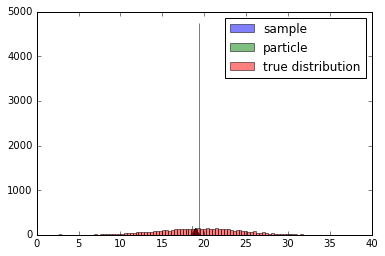

In [166]:
from matplotlib import pyplot
i = 507
#plt.hist9ancestor[i],100, label='particle')
[x_map, U, marginal_loglikelihood, joint_loglikelihood] = Do_Kalman_Likelihood(Y[:T-2], sigma2v, Q)
drawsample = np.random.normal(x_map[i],U[1][i], N)
#plt.hist(drawsample,100, label='true distribution')
#bins = np.linspace(, , 100)
bins = 100

pyplot.hist(X[i], bins, alpha=0.5, label='sample')
pyplot.hist(ancestor[i], bins, alpha=0.5, label='particle')
pyplot.hist(drawsample, bins, alpha=0.5, label='true distribution')
pyplot.legend(loc='upper right')
plt.legend(loc='best')
pyplot.show()

$\sigma^2_e = 0.5$

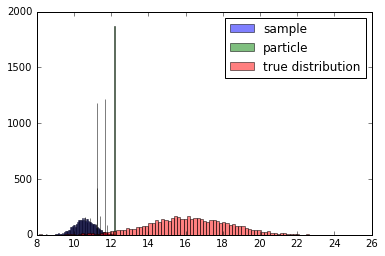

In [176]:
from matplotlib import pyplot
i = 507
#plt.hist9ancestor[i],100, label='particle')
[x_map, U, marginal_loglikelihood, joint_loglikelihood] = Do_Kalman_Likelihood(Y[:T-2], sigma2v, Q)
drawsample = np.random.normal(x_map[i],U[1][i], N)
#plt.hist(drawsample,100, label='true distribution')
#bins = np.linspace(, , 100)
bins = 100

pyplot.hist(X[i], bins, alpha=0.5, label='sample')
pyplot.hist(ancestor[i], bins, alpha=0.5, label='particle')
pyplot.hist(drawsample, bins, alpha=0.5, label='true distribution')
pyplot.legend(loc='upper right')
plt.legend(loc='best')
pyplot.show()

$\sigma^2_v = 5.0$

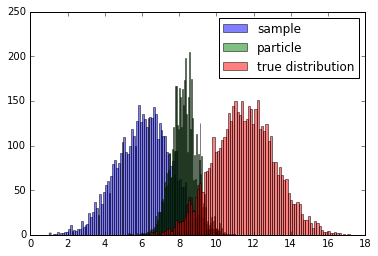

In [192]:
from matplotlib import pyplot
i = 507
#plt.hist9ancestor[i],100, label='particle')
[x_map, U, marginal_loglikelihood, joint_loglikelihood] = Do_Kalman_Likelihood(Y[:T-2], sigma2v, Q)
drawsample = np.random.normal(x_map[i],U[1][i], N)
#plt.hist(drawsample,100, label='true distribution')
#bins = np.linspace(, , 100)
bins = 100

pyplot.hist(X[i], bins, alpha=0.5, label='sample')
pyplot.hist(ancestor[i], bins, alpha=0.5, label='particle')
pyplot.hist(drawsample, bins, alpha=0.5, label='true distribution')
pyplot.legend(loc='upper right')
plt.legend(loc='best')
pyplot.show()

$\sigma^2_v = 25$

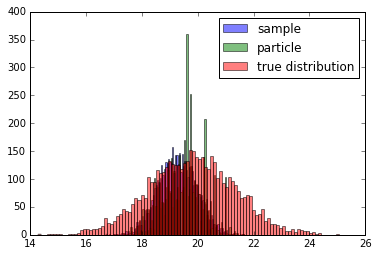

In [181]:
from matplotlib import pyplot
i = 507
#plt.hist9ancestor[i],100, label='particle')
[x_map, U, marginal_loglikelihood, joint_loglikelihood] = Do_Kalman_Likelihood(Y[:T-2], sigma2v, Q)
drawsample = np.random.normal(x_map[i],U[1][i], N)
#plt.hist(drawsample,100, label='true distribution')
#bins = np.linspace(, , 100)
bins = 100

pyplot.hist(X[i], bins, alpha=0.5, label='sample')
pyplot.hist(ancestor[i], bins, alpha=0.5, label='particle')
pyplot.hist(drawsample, bins, alpha=0.5, label='true distribution')
pyplot.legend(loc='upper right')
plt.legend(loc='best')
pyplot.show()

In [15]:
def Do_Kalman_Likelihood(y, sigma2obs, sigma2e):
    """MAP solution, inverse covariance matrix, and marginal loglikelihood of state-space model

    :param y: Observations (K,)
    :param sigma2obs: Variance of observation noise (can be scalar or vector)
    :param sigma2e: Variance of process noise
    :return: x_map, L, marginal_loglikelihood, joint_loglikelihood
    """
    # Build diagonals of information matrix
    sigma2obs *= np.ones(len(y))
    D = 1. / sigma2obs + 2. / sigma2e
    D[-1] = 1. / sigma2obs[-1] + 1. / sigma2e
    B = -np.ones(len(D)) / sigma2e
    B[0] = 0.
    
    # Solve, assuming x_init=0 for simplicity
    #L = sp.linalg.cholesky_banded((D, B), lower=True)
    U = sp.linalg.cholesky_banded((B, D), lower=False)

    x_map = sp.linalg.cho_solve_banded([U, False], y / sigma2obs)

    # Compute joint and marginal probabilities
    joint_loglikelihood = -.5 * ((np.sum(np.diff(x_map)**2) + x_map[0]**2) / sigma2e +
                                 np.sum((y - x_map)**2 / sigma2obs) +
                                 (len(y) * np.log(2*np.pi*sigma2e * 2*np.pi) + np.sum(np.log(sigma2obs))))
    marginal_loglikelihood = len(y)/2. * np.log(2*np.pi) + joint_loglikelihood - np.sum(np.log(U[-1]))
    return x_map, U, marginal_loglikelihood, joint_loglikelihood

In [67]:
likelihoodxxx = np.empty(len(sigma2e))
for i in range(len(sigma2e)):
    Q = sigma2e[i]
    [x_map, U, marginal_loglikelihood, joint_loglikelihood] = Do_Kalman_Likelihood(Y[:-1], sigma2v, Q)
    likelihoodxxx[i] = marginal_loglikelihood

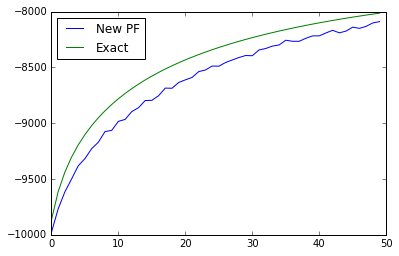

In [92]:
plt.plot(loglikelihood_withresampling,label='New PF')
plt.plot(likelihoodxxx,label='Exact')
#plt.ylim([-10500,-8000])
plt.legend(loc='best')

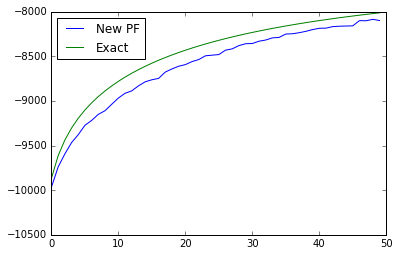

In [99]:
plt.plot(loglikelihood_withresampling,label='New PF')
plt.plot(likelihoodxxx,label='Exact')
plt.ylim([-10500,-8000])
plt.legend(loc='best')

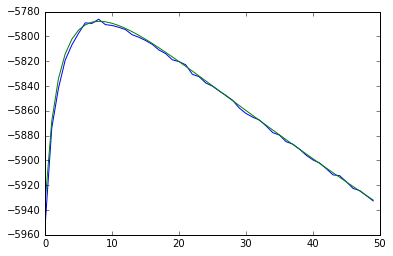

In [194]:
plt.plot(loglikelihood_withresampling,label='New PF_Neff')
plt.plot(likelihoodxxx,label='Exact')

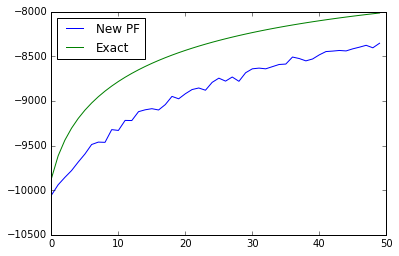

In [30]:
plt.plot(loglikelihood_withresampling,label='New PF')
plt.plot(likelihoodxxx,label='Exact')
plt.legend(loc='best')

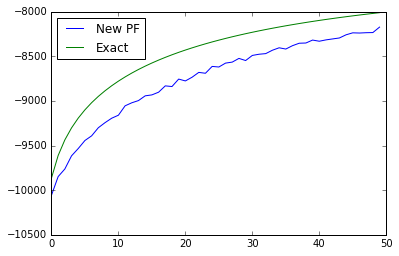

In [163]:
plt.plot(loglikelihood_withresampling,label='New PF')
plt.plot(likelihoodxxx,label='Exact')
plt.legend(loc='best')

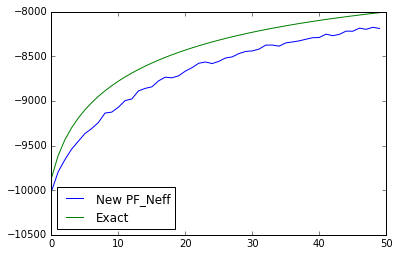

In [176]:
plt.plot(loglikelihood_withresampling,label='New PF_Neff')
plt.plot(likelihoodxxx,label='Exact')
plt.legend(loc='best')

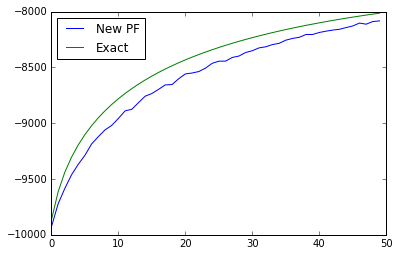

In [79]:
plt.plot(loglikelihood_withresampling,label='New PF')
#plt.ylim([-10500,-8000])
plt.plot(likelihoodxxx,label='Exact')
plt.legend(loc='best')